# File Setup

In [1]:
import os
print(os.listdir())
directory_path = ''

#from google.colab import drive
#import sys
#drive.mount('/content/drive')
#directory_path = '/content/drive/MyDrive/Quantum/'
#sys.path.append('/content/drive/MyDrive/Quantum')
# print(os.listdir(directory_path))

['dense_small.param', '.DS_Store', 'quantum_experiments', 'DiscreteVariationalParameterizationsDeepV2.py', 'Mutual_Information_Transformer.ipynb', '__pycache__', 'DiscreteVariationalParameterizationsDeepV3.py', 'README.md', 'Mutual_Information_Maximizing_Model.ipynb', 'temp.txt', '.ipynb_checkpoints', '.git', 'QuantumSimulatorDataset.py', 'GibbsSampling.py', '.idea']


In [221]:
!pip install torch
!pip install torchmetrics
!pip install qiskit-aer
!pip install qiskit
!pip install pylatexenc
!pip install tqdm
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 2.1 MB/s eta 0:00:0000:0100:01m


In [412]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import ast
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.clustering import MutualInfoScore
from sklearn.metrics import mutual_info_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from QuantumSimulatorDataset import QuantumSimulationDatasetFast, generate_circuit_params
from sklearn.model_selection import train_test_split

# MI and Entropy

In [413]:
def entropy(X):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    
    # Count the occurrences of each unique value
    unique_vals, counts = X_flat.unique(return_counts=True)
    probabilities = counts.float() / counts.sum()
    entropy = -torch.sum(probabilities * torch.log(probabilities))
        
    return entropy.item()

def mutual_info_loss(X, Y):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    Y_flat = Y.view(-1)
    
    return -mutual_info_score(X_flat, Y_flat)

class MutualInformationLoss(nn.Module):
    def forward(self, input, target):
        X_flat = input.view(-1)
        Y_flat = target.view(-1)
        
        # Compute mutual information
        mi = mutual_info_score(X_flat, Y_flat)
    
        # Convert mutual information to a tensor and return the negative as loss
        mi_tensor = torch.tensor(mi, dtype=torch.float32, requires_grad=True).to(input.device)
        return -mi_tensor
    
def calc_binary_accuracy(predictions, targets):
    correct = (predictions == targets).float().sum()
    accuracy = correct / targets.numel()
    return accuracy.item()
    

# Model Definition

In [429]:
class QuantumTransformer_V2(nn.Module):
    def __init__(
            self,
            num_qbits,
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
            device,
            num_ones
    ):
        super(QuantumTransformer_V2, self).__init__()
        self.src_emb = nn.Embedding(2, embedding_size)
        self.src_position_emb = nn.Embedding(num_qbits, embedding_size)
        self.tgt_emb = nn.Embedding(2, embedding_size)
        self.tgt_position_emb = nn.Embedding(num_qbits, embedding_size)
        self.device = device
        self.num_ones = num_ones
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout
        )
        self.fc_out = nn.Linear(embedding_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
        
    def create_mask(self, size):
        mask = torch.tril(torch.ones(size, size)).to(self.device)
        return mask
    
    def forward(self, src, tgt):
        batch_size, input_dim = src.shape
        batch_size, output_dim = tgt.shape
        
        src_positions = torch.arange(0, input_dim).unsqueeze(0).expand(batch_size, input_dim).to(self.device)
        tgt_positions = torch.arange(0, output_dim).unsqueeze(0).expand(batch_size, output_dim).to(self.device)
        
        embed_src = self.dropout(self.src_emb(src) + self.src_position_emb(src_positions))
        embed_tgt = self.dropout(self.tgt_emb(tgt) + self.tgt_position_emb(tgt_positions))
        
        src_mask = self.create_mask(input_dim)
        tgt_mask = self.create_mask(output_dim)
        
        # Pass both src and tgt embeddings through the transformer
        # Changing forward function to Seq2Seq
        out = self.transformer(
            embed_src.permute(1, 0, 2),  # (S, N, E)
            embed_tgt.permute(1, 0, 2),  # (T, N, E)
            src_key_padding_mask=None,   
            tgt_key_padding_mask=None,   
            memory_key_padding_mask=None, 
            src_mask=src_mask,
            tgt_mask=tgt_mask
        )
        
        out = self.fc_out(out.permute(1, 0, 2))
        out = self.sigmoid(out) # (N, S, 1)
        return out.squeeze(-1) # (N, S)
    
    # Issue: predicting S-1 length sequence may not have num_ones amount of ones
    def conservation_ones_process(self, probabilities):
        sorted_indices = torch.argsort(probabilities, dim=1, descending=True)
        threshold_output = torch.zeros_like(probabilities)
    
        for j in range(probabilities.size(0)):
            threshold_output[j, sorted_indices[j, : self.num_ones]] = 1
        
        return threshold_output
    

# Model Initialization and Training

In [432]:
#Version 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

#Hyperparameters
num_iterations = 500
learning_rate = 1e-4
batch_size = 40
binary_vocab_size = 2
embedding_size = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1
qbits = 12
forward_expansion = 4
inverse_density = 3
num_qbits = 12
num_ones = int(num_qbits/inverse_density)
num_final_per_initial = 4

model = QuantumTransformer_V2(qbits, embedding_size, num_heads, num_encoder_layers, num_decoder_layers, forward_expansion, dropout, device, num_ones).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

#params = generate_circuit_params(0,num_qbits)
params = generate_circuit_params(file_name = directory_path + 'dense_small.param')
dataset = QuantumSimulationDatasetFast(params, batch_size, num_final_per_initial, device, inverse_density=inverse_density)
print('Device:', device)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Device: cpu


In [435]:
train_BCELoss_array = []
train_BAcc_array = []
train_MI_array = []
test_MI_array = []
test_BAcc_array = []
upperBound = 0

print('Training')
for idx, (initial_state, final_state) in enumerate(dataset):
    model.train()    
    initial_state = initial_state.to(device).long()
    final_state = final_state.to(device).long()
        
    optimizer.zero_grad()

    # Forward and backward pass
    out = model(initial_state, initial_state)    
    loss = criterion(out, final_state.float())    
    loss.backward()
    optimizer.step()
            
    # Training Metrics
    train_predictions = model.conservation_ones_process(out)
    train_mutual_info = mutual_info_score(final_state.cpu().reshape(-1), train_predictions.cpu().reshape(-1))
    initial_entropy = entropy(initial_state)
    train_BAccuracy = calc_binary_accuracy(train_predictions, final_state)
    
    # Tracking
    train_BCELoss_array.append(loss.item())
    train_BAcc_array.append(train_BAccuracy)
    train_MI_array.append(train_mutual_info)
    
    if idx == 0:
        upperBound = mutual_info_score(initial_state.cpu().reshape(-1), final_state.cpu().reshape(-1))
    if idx % 10 == 0:
        print('| Iteration', f"{idx:03}", ' > BCELoss(Y,ȳ):', f"{loss:,.5f}",
              ' Train Acc:', f"{train_BAccuracy:,.5f}",
              ' I(Y,ȳ):', f"{train_mutual_info:,.5f}",
              ' I(X,Y):', f"{upperBound:,.5f}")
    if idx > num_iterations:
        print('Training Terminated')
        break

Training
| Iteration 000  > BCELoss(Y,ȳ): 2.47064  Train Acc: 0.62917  I(Y,ȳ): 0.01346  I(X,Y): 0.01346
| Iteration 010  > BCELoss(Y,ȳ): 0.63959  Train Acc: 0.55417  I(Y,ȳ): 0.00000  I(X,Y): 0.01346
| Iteration 020  > BCELoss(Y,ȳ): 0.64559  Train Acc: 0.51667  I(Y,ȳ): 0.00390  I(X,Y): 0.01346
| Iteration 030  > BCELoss(Y,ȳ): 0.63903  Train Acc: 0.54167  I(Y,ȳ): 0.00049  I(X,Y): 0.01346
| Iteration 040  > BCELoss(Y,ȳ): 0.64280  Train Acc: 0.57083  I(Y,ȳ): 0.00059  I(X,Y): 0.01346
| Iteration 050  > BCELoss(Y,ȳ): 0.63737  Train Acc: 0.52917  I(Y,ȳ): 0.00178  I(X,Y): 0.01346
| Iteration 060  > BCELoss(Y,ȳ): 0.63760  Train Acc: 0.57083  I(Y,ȳ): 0.00059  I(X,Y): 0.01346
| Iteration 070  > BCELoss(Y,ȳ): 0.63879  Train Acc: 0.56250  I(Y,ȳ): 0.00012  I(X,Y): 0.01346
| Iteration 080  > BCELoss(Y,ȳ): 0.63840  Train Acc: 0.56250  I(Y,ȳ): 0.00012  I(X,Y): 0.01346
| Iteration 090  > BCELoss(Y,ȳ): 0.63587  Train Acc: 0.58333  I(Y,ȳ): 0.00194  I(X,Y): 0.01346
| Iteration 100  > BCELoss(Y,ȳ): 0.63751 

KeyboardInterrupt: 

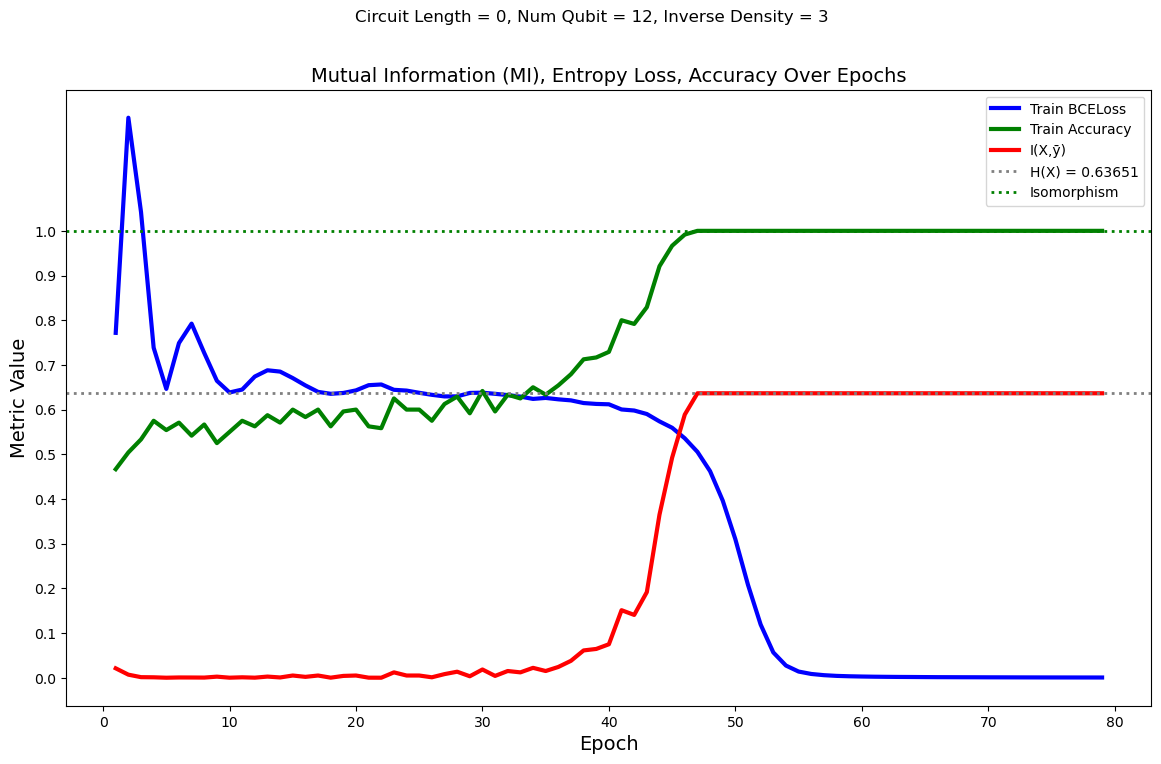

In [428]:
# Plotting Training and Validation
train_BCELoss_array = np.array(train_BCELoss_array)
train_BAcc_array = np.array(train_BAcc_array)
train_MI_array = np.array(train_MI_array)

window_size = 10
smoothed_train_BCELoss = np.convolve(train_BCELoss_array, np.ones(window_size)/window_size, mode='valid')
smoothed_rain_BAcc = np.convolve(train_BAcc_array, np.ones(window_size)/window_size, mode='valid')
smoothed_train_MI = np.convolve(train_MI_array, np.ones(window_size)/window_size, mode='valid')

epochs = np.arange(1, len(train_MI_array) + 1)

plt.style.use('default')
plt.figure(figsize=(14, 8))

plt.plot(epochs, train_BCELoss_array, color='blue', linestyle='-', linewidth=3, label='Train BCELoss')
plt.plot(epochs, train_BAcc_array, color='green', linestyle='-', linewidth=3, label='Train Accuracy')
plt.plot(epochs, train_MI_array, color='red', linestyle='-', linewidth=3, label='I(X,ȳ)')
plt.axhline(y=upperBound, color='gray', linestyle=':', linewidth=2, label=f'H(X) = {upperBound:,.5f}')
plt.axhline(y=1.0, color='green', linestyle=':', linewidth=2, label='Isomorphism')

plt.title('Mutual Information (MI), Entropy Loss, Accuracy Over Epochs', fontsize=14)
plt.suptitle('Circuit Length = 12, Num Qubit = 12, Inverse Density = 3', fontsize=12)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(loc='best', fontsize=10)
plt.show()